<a href="https://colab.research.google.com/github/oriol-pomarol/codegeo_workshops/blob/main/3_understanding_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. How do they work? - understanding Neural Networks

In the previous workshop, we built a Random Forest model. Today we will delve into a more complex machine learning approach: deep learning models, specifically Neural Networks. Neural Networks consist of three primary layers: the input layer, hidden layers (one or more), and the output layer.

There are various types of Neural Networks with distinct structures, including Convolutional Neural Networks (CNN) for image recognition or spatial data, Long Short-Term Memory networks (LSTM) for sequence data such as time series, and Multilayer perceptrons for general tasks. We are going to focus on the latter, as it is the simplest and and serves as a good base for the rest.

## 3.1 Problem definition

We use the same dataset as in the previous workshop, in which we want to predict the water level at the Hagestein station using a selection of five meteorological and hydrological variables: the discharge of the Rhine and Meuse at the Dutch border, the water level of the North Sea, precipitation and evaporation.

**Dataset**: We have daily measurements of the described variables spanning from 1981 to 2019. For more information about the data sources, we encourage you to check [Hauswirth et al. (2021)](https://doi.org/10.1016/j.advwatres.2021.104017).

![picture](images/hagestein_water_level.jpg)

*Door Rijksdienst voor het Cultureel Erfgoed, CC BY-SA 4.0, https[]()://commons.wikimedia.org/w/index.php?curid=24032939*

### Import data and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data_url =  "https://raw.githubusercontent.com/Jignesh1594/CodeGeoworkshop_02_understanding_RF/master/data.csv"
data = pd.read_csv(data_url, delimiter=",", on_bad_lines='skip')
input_data = data[['WLHv', 'RH', 'EV24', 'QMeuse', 'QRhine']]
output_data = data[['value']]

### Split the data into train and test dataset


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1, shuffle=False)

## 3.2 A simple case scenario - shallow networks

### Predicting with NNs: neuron activation

To simplify the model training, we will use a subset of our training data, taking only two input variables, the discharge from the Meuse and Rhine respectively, and only the first 1000 observations.

In [3]:
# Subset data to 2 columns
X_train_subset = X_train.iloc[:1000, -2:]
X_test_subset = X_test.iloc[:1000, -2:]

y_train_subset = y_train.iloc[:1000, :]
y_test_subset = y_test.iloc[:1000, :]

Let's start by training a small, shallow neural network of only one hidden layer with three units in it, so we can easily see what is going on. Lets train it on our subset data and see the shape of our weights.

In [4]:
from sklearn.neural_network import MLPRegressor

# Create a model
model = MLPRegressor(hidden_layer_sizes=(3), activation='relu', max_iter=1000, random_state=10)
model.fit(X_train_subset.values, y_train_subset.values.ravel())

# Get the weights and biases
all_weights = model.coefs_
all_biases = model.intercepts_

# Print the shape of the weights and biases
pd.DataFrame({
    'Layer': [i+1 for i in range(len(all_weights))],
    'Weights Shape': [all_weights[i].shape for i in range(len(all_weights))],
    'Biases Shape': [all_biases[i].shape for i in range(len(all_biases))]
}).set_index('Layer')

c:\Users\4946057\Miniconda3\envs\project_4946057\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,Weights Shape,Biases Shape
Layer,,
1,"(2, 3)","(3,)"
2,"(3, 1)","(1,)"


So, as we can see from the shape of the weights, we get two initial inputs that go to three hidden units (also called neurons), resulting in a 2x3 matrix. Additionally, we get one bias term for each of the hidden units, resulting in a vector of size 3.

In the second layer, we start from the three hidden units, and end up in the one output, leaving a matrix of 3x1 for the weights, and a single bias value for the output unit.

In total, this amounts to 13 trainable parameters. Here we can see a sketch with the model structure, with its weights and biases:

![picture](images/nn_structure.png)

Let us now see how the neural network predicts. To do so, we will use the first point from the training data as an example. Let us see what are the input values.

In [5]:
pd.set_option('display.float_format', '{:n}'.format)
X_train_subset.iloc[[0]]

,QMeuse,QRhine
0,290,2579


Now let us calculate what will be the value of our first hidden unit. To do so, let us visualize the weights that connect the inputs to it.

In [6]:
# Print the weights that go to the first hidden unit, and the bias
pd.set_option('display.float_format', '{:.2e}'.format)
pd.DataFrame({
    'Feature': list(X_train_subset.columns) + ['Bias'],
    'Value': list(all_weights[0][:, 0]) + [all_biases[0][0]]
})

,Feature,Value
0,QMeuse,3.19e-02
1,QRhine,-1.54e-02
2,Bias,-1.24e+00


Perfect, now that we know the weights for each of the input, we can easily calculate the value of our neuron like we would in a simple linear regression. This results will need to be fed to the activation function of choice, in our case ReLU, which ensures that the output is not linear, enabling our neural network to learn literally *any* function.

The Relu function is quite simple to implement, for any negative value the output is zero, and for any positive value the output is unchanged.

$$Y_1 = f_{act}(X_1 \cdot w_1 + X_2 \cdot w_2 + b)$$
$$Y_1 = ReLU(290 \cdot 3.19e^{-2} + 2579 \cdot -1.54e^{-2} - 1.24)$$
$$Y_1 = ReLU(-31.78) = 0$$

So, the output of our neuron is zero. We can do the same easily for all three neurons in code by using the dot function in numpy. Then we simply need to apply ReLU, which means setting any negative value to zero.

In [7]:
# Find the output of the first hidden unit
hidden_unit_output = np.dot(X_train_subset.iloc[[0]], all_weights[0]) + all_biases[0]

# Print the output before applying ReLU
print("Neuron Activation:")
print("Before ReLU:", hidden_unit_output)

# Apply ReLU
hidden_unit_output_relu = np.maximum(0, hidden_unit_output)

# Print the output after applying ReLU
print("After ReLU:", hidden_unit_output_relu)

Neuron Activation:
Before ReLU: [[-31.78085164 587.60246325  -0.72494184]]
After ReLU: [[  0.         587.60246325   0.        ]]


Finally, we can use the dot function again using the weights in the last layer to obtain the output. Let's see how this looks, and compare it to the actual prediction. Because this is already the output of our model, we don't apply the ReLU function this time - we want to be able to predict negative values too!

In [8]:
# Print the ouptput of the model both using the predict function and manually
print("Model output:", model.predict(X_train_subset.iloc[[0]].values))

last_unit_output = np.dot(hidden_unit_output_relu, all_weights[1]) + all_biases[1]
print("Manually calculated output:", last_unit_output)

Model output: [225.98599972]
Manually calculated output: [[225.98599972]]


The result is indeed the same! Here is a small schematic summarizing what we have done:

![picture](images/nn_prediction.png)

### Training NNs: visualizing the model improvement

Now we know how neural networks predict, but how do they actually train? It is a rather complicated topic so we won't go into the details, but basically it calibrates the weights and biases progressively to optimize a certain loss function, usually MSE. To do so, it computes the gradient of the loss as a function of the weights (and biases), to find what is the direction with a steepest descent, and taking a step in that direction. The size of the step is what we call the learning rate. If we do that for a few iterations, we hope to reach the values of the weights that minimize the loss.

We can see how the loss evolved for each iteration with the following plot.



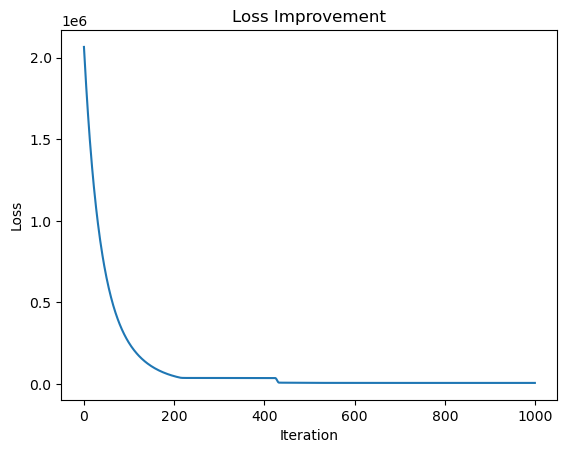

In [9]:
# Plot the loss at each iteration
plt.plot(model.loss_curve_)
plt.title('Loss Improvement')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

So, at each iteration, the model goes through all of the training data and, through backpropagation of the loss, the optimizer (in our case, Adam) changes the weights of our network to slowly improve the model accuracy. If the line becomes horizontal, it means that our model is no longer learning anything.

If you are interested about learning more about how neural networks train, I recommend you watch the Chapters 2, 3 and 4 of the following Youtube series by 3Blue1Brown:

https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=GhO5UD2aHo97jKDG

## 3.3 The power of deep learning - tuning our NN

Let us now use the full data and train a fully fledged neural network, in order to unleash the power of deep learning. To start, we will widen our hidden layer to 1000 neurons. Because it is a fully connected neural network, we have a connection from each of the neurons in the previous layer to each of the neurons in the next, resulting in many more connections than one might expect. Let's quickly compute to how many trainable parameters that amounts.

In [10]:
# Fit a wide model
model_wide = MLPRegressor(hidden_layer_sizes=(1000), activation='relu', max_iter=1000, random_state=10)
model_wide.fit(X_train.values, y_train.values.ravel())

# Print the number of trainable parameters
n_params = sum([w.size for w in model_wide.coefs_] + [b.size for b in model_wide.intercepts_])
print("Number of trainable parameters:", n_params)

Number of trainable parameters: 7001


That is already much more than the 13 before. But that is not really *deep*. To do that, we need to add more hidden layers. To make the models comparable, however, we reduce the number of units per layer, ending up with 5 layers of 50 units each.

In [11]:
# Fit a deep model
model_deep = MLPRegressor(hidden_layer_sizes=(50, 50, 50, 50, 50), activation='relu', max_iter=1000, random_state=10)
model_deep.fit(X_train.values, y_train.values.ravel())

# Print the number of trainable parameters
n_params = sum([w.size for w in model_deep.coefs_] + [b.size for b in model_deep.intercepts_])
print("Number of trainable parameters:", n_params)

Number of trainable parameters: 10551


Perfect, now let's compare how the two are able to learn from the training data. We will also add the small network from before to see how much we have improved.

Small model RMSE: 97.1327118560588
Wide model RMSE: 33.83364314537003
Deep model RMSE: 23.473595242457076


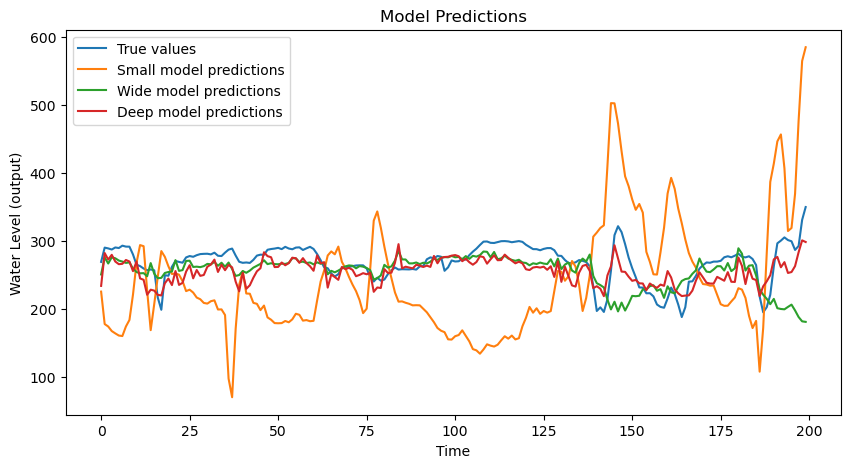

In [15]:
# Predict the first 200 training values
y_pred_small = model.predict(X_train.values[:200, -2:])
y_pred_wide = model_wide.predict(X_train.values[:200])
y_pred_deep = model_deep.predict(X_train.values[:200])

# Print the RMSE for each model
from sklearn.metrics import mean_squared_error

rmse_small = mean_squared_error(y_train.values[:200], y_pred_small, squared=False)
rmse_wide = mean_squared_error(y_train.values[:200], y_pred_wide, squared=False)
rmse_deep = mean_squared_error(y_train.values[:200], y_pred_deep, squared=False)

print("Small model RMSE:", rmse_small)
print("Wide model RMSE:", rmse_wide)
print("Deep model RMSE:", rmse_deep)

# Plot the predictions
plt.figure(figsize=(10, 5))
plt.plot(y_train.values[:200], label='True values')
plt.plot(y_pred_small, label='Small model predictions')
plt.plot(y_pred_wide, label='Wide model predictions')
plt.plot(y_pred_deep, label='Deep model predictions')
plt.legend()
plt.title('Model Predictions')
plt.xlabel('Time')
plt.ylabel('Water Level (output)')
plt.show()

It is quite clear that we have come a long way since our small model. Between the other two though, the differences are more subtle.

In general, deeper models are able to learn more complex patterns, as each layers adds a level of abstractions to the concepts in can capture. However, it is important to remember that a single layer neural network with arbitrary number of units is enough to capture any function, that is why we call them universal approximators.

To visually see how the changes in the network structure affect its predictions, you can do that in a fun and interactive way through the Neural Neural Playground, provided by Tensorflow:

http://playground.tensorflow.org/

### Effect of most important hyperparameters.

The structure of the neural network, which we have changed before, is also a hyperparameter, but neural networks have many more of those. As we know, changing those can have quite a big impact on the model's performance an computational impact. To simplify the process of finding the right hyperparameters, we have compiled a table explaining what you should aim for in each of them.

| Category             | Hyperparameter       | Description                                         | Default Value         | Tuning Advice                                 | Example Tuning Range                                   |
|----------------------|----------------------|-----------------------------------------------------|-----------------------|-----------------------------------------------|----------------------------------------------------------|
| Network Architecture | `number_of_layers`   | Number of hidden layers in the network.             | `1`                   | Increase for more complex problems, but beware of overfitting. | 1 to 10.                         |
|                      | `neurons_per_layer`  | Number of neurons in each hidden layer.             | `32`                  | Adjust based on problem complexity and dataset size. | 10 to 1000.                     |
|                      | `activation_function`| The function used to get the output of a node.      | `relu`                | Choose based on problem type and complexity. | `relu`, `sigmoid`, `tanh`, `softmax`.                    |
| Training             | `learning_rate`      | Step size at each iteration while moving toward a minimum of a loss function. | `0.01`               | Decrease if training process is unstable, increase if training is slow. | 0.0001 to 1.0.                                           |
|                      | `epochs`             | Number of complete passes through the training dataset. | `10`                  | Increase until no further improvement. | 10 to 1000.                     |
|                      | `optimizer`          | The algorithm used to change the attributes of the neural network such as weights and learning rate in order to reduce the losses. | `adam` | Choose based on problem type and complexity. | `adam`, `sgd`, `rmsprop`, `adagrad`.                     |

## 3.4 Final remarks

Well, we have learnt a lot about Neural Networks in this workshop. Now it is time for you to practice a bit more with them. For example, you could try to tune one of the other hyperparameters in the table, and see its effect in the training loss and predictions. Feel free to copy-paste code from the previous chapters!

In [ ]:
# Set hyperparameter values to tune


# Train a model for each of these values



In [ ]:
# Plot the training curves for the models

In [ ]:
# Plot the predictions of the stored models on the test data
